In [1]:
import pandas as pd
import georinex as gr
import misc
from plots import *
import copy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader, PosReader, RinexReader

# Prepare the data

In [2]:
# Load log files
measurements_log = ['Raw', 'Fix']
measurements_RINEX = sum([[f"{y}{x}" for y in ['C', 'L', 'D', 'S']] for x in ['1C', '5Q', '2I', '5P']], [])
# measurements_RINEX = ['L1C', 'L5Q']
# # 'C1C', 'C5Q', 'C2I', 'C5P'

logs = []

log = LogReader(manufacturer="Google", device="Pixel 7", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_GooglePixel7_20230801110405_modified.txt")
log.ref = RinexReader('Reference', 
            filepath='../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-14-05.23O',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX, sampling=1)
log.pos = PosReader('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-14-05.pos')
logs.append(log)

# log = LogReader(manufacturer="Google", device="Pixel Watch", specifiedTags=measurements_log, mode="mimir", 
#                 filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_GooglePixelWatch_20230801110404_modified.txt")
# log.ref = gr.load('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-14-05.23O',
#               tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
#               meas=measurements_RINEX)
# log.pos = PosReader('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover /NMND17420010S_2023-08-01_08-14-05.pos')
# logs.append(log)

# log = LogReader(manufacturer="OnePlus", device="Nord 2", specifiedTags=measurements_log, mode="mimir", 
#                 filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_OnePlusNord2_20230811103018_modified.txt")
# log.ref = gr.load('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-11_07-40-20.23O',
#               tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
#               meas=measurements_RINEX)
# log.pos = PosReader('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-11_07-40-20.pos')
# logs.append(log)

# log = LogReader(manufacturer="Samsung", device="A52", specifiedTags=measurements_log, mode="mimir", 
#                 filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_SamsungA52_20230811101903_modified.txt")
# log.ref = gr.load('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-11_07-29-33.23O',
#               tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
#               meas=measurements_RINEX)
# log.pos = PosReader('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-11_07-29-33.pos')
# logs.append(log)

# log = LogReader(manufacturer="Xiaomi", device="11T", specifiedTags=measurements_log, mode="mimir", 
#                 filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_Xiaomi11T_20230801111451_modified.txt")
# log.ref = gr.load('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-24-35.23O',
#               tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
#              meas=measurements_RINEX)
# log.pos = PosReader('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-24-35.pos')
# logs.append(log)

device_list = [log.device for log in logs]

In [3]:
log.raw.loc[log.raw['prn'].isin(['C20-L5']), ['CarrierFrequencyHz']]


,CarrierFrequencyHz
datetime,
2023-08-01 08:04:08.082,1.176450e+09
2023-08-01 08:04:11.227,1.176450e+09
2023-08-01 08:04:12.253,1.176450e+09
2023-08-01 08:04:14.230,1.176450e+09
2023-08-01 08:04:15.265,1.176450e+09
...,...
2023-08-01 08:13:38.277,1.176450e+09
2023-08-01 08:13:42.268,1.176450e+09
2023-08-01 08:13:43.267,1.176450e+09


In [4]:
log.pos.df

,provider,timestamp,latitude,longitude,altitude
datetime,,,,,
2023-08-01 08:02:24,REF,1.690877e+09,61.449220,23.856275,163.0174
2023-08-01 08:02:25,REF,1.690877e+09,61.449220,23.856275,163.0176
2023-08-01 08:02:26,REF,1.690877e+09,61.449220,23.856275,163.0219
2023-08-01 08:02:27,REF,1.690877e+09,61.449220,23.856275,163.0271
2023-08-01 08:02:28,REF,1.690877e+09,61.449221,23.856274,163.0304
...,...,...,...,...,...
2023-08-01 08:14:01,REF,1.690878e+09,61.449225,23.856271,163.0527
2023-08-01 08:14:02,REF,1.690878e+09,61.449225,23.856272,163.0551
2023-08-01 08:14:03,REF,1.690878e+09,61.449223,23.856275,162.7483


In [5]:
log.ref.df

,time,sv,signal,doppler,phase,pseudorange,snr,prn,system,frequency,pseudorange_rate,pseudorange_error,phase_rate,phase_error,doppler_error
0,2023-08-01 08:04:08,C05,2I,30.051,2.085037e+08,4.004095e+07,43.200,C05-L1,C,L1,NaN,NaN,NaN,NaN,NaN
1,2023-08-01 08:04:08,C08,2I,-1277.341,2.026462e+08,3.891607e+07,42.959,C08-L1,C,L1,NaN,NaN,NaN,NaN,NaN
2,2023-08-01 08:04:08,C13,2I,-1009.576,1.981520e+08,3.805301e+07,47.700,C13-L1,C,L1,NaN,NaN,NaN,NaN,NaN
3,2023-08-01 08:04:08,C19,2I,3189.411,1.282426e+08,2.462764e+07,48.747,C19-L1,C,L1,NaN,NaN,NaN,NaN,NaN
4,2023-08-01 08:04:08,C19,5P,2403.480,9.664418e+07,2.462765e+07,50.649,C19-L5,C,L5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25951,2023-08-01 08:13:46,R09,1C,-2728.150,1.172394e+08,2.195525e+07,43.268,R09-L1,R,L1,510.850,0.170,2727.731,0.728,-0.748
25952,2023-08-01 08:13:46,R10,1C,525.375,1.157771e+08,2.171956e+07,40.704,R10-L1,R,L1,-98.668,0.188,-525.960,0.917,-1.086
25953,2023-08-01 08:13:46,R17,1C,-3854.008,1.207863e+08,2.257188e+07,47.652,R17-L1,R,L1,720.207,0.092,3853.996,0.574,0.108
25954,2023-08-01 08:13:46,R18,1C,-1335.944,1.036394e+08,1.941522e+07,50.524,R18-L1,R,L1,250.215,0.168,1335.667,0.884,-0.523


In [6]:
# Compute ENU errors
ref_enu = [61.44922404, 23.8562781, 162.711]
for log in logs:
    # Convert to ENU based on reference
    log.fix[["east", "north", "up"]] = log.fix.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')

    # window = 1
    # log.pos.df["latitude_avg"] = log.pos.df["latitude"].rolling(window).mean()
    # log.pos.df["longitude_avg"] = log.pos.df["longitude"].rolling(window).mean()
    # log.pos.df["altitude_avg"] = log.pos.df["altitude"].rolling(window).mean()

    log.pos.df[["east", "north", "up"]] = log.pos.df.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')

    # Align/interpolates dataframes
    pos_A, pos_B = log.fix[["east", "north", "up"]].align(log.pos.df[["east", "north", "up"]])
    log.diff = pos_B.interpolate(method='time') - pos_A.interpolate(method='time')
    log.diff.dropna(how='all', inplace=True)
    
    log.diff[["2D_error"]] = log.diff.apply(
        lambda row: misc.getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log.diff[["3D_error"]] = log.diff.apply(
        lambda row: misc.get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')

    print(f"--- {log.device} ---")
    print(log.diff[["east", "north", "up", "2D_error", "3D_error"]].describe())

--- Pixel 7 ---
             east       north          up    2D_error    3D_error
count  627.000000  627.000000  627.000000  627.000000  627.000000
mean     0.371880   -0.444763   -6.927663    1.824681    7.572412
std      1.300549    1.969238    3.090132    1.603494    2.468003
min     -6.172954   -6.211736  -20.060630    0.078894    1.564468
25%     -0.010505   -1.351840   -7.954781    0.922860    6.305800
50%      0.329247   -0.965794   -6.629866    1.448422    6.875208
75%      0.807818   -0.008581   -6.038846    2.067478    8.150087
max     10.772448   14.858674   20.332651   15.984926   25.863770


In [7]:
log.diff

,east,north,up,2D_error,3D_error
datetime,,,,,
2023-08-01 08:04:07.939,-6.172954,-0.333597,0.125125,6.181962,6.183228
2023-08-01 08:04:08.000,-5.645087,-0.408292,0.376720,5.659833,5.672356
2023-08-01 08:04:09.000,2.975304,-1.605938,4.496230,3.381046,5.625616
2023-08-01 08:04:09.900,10.772448,-2.602681,8.196770,11.082399,13.784289
2023-08-01 08:04:10.000,10.551883,-2.516063,7.799606,10.847710,13.360639
...,...,...,...,...,...
2023-08-01 08:14:01.000,-0.008428,-0.805151,-7.276300,0.805195,7.320716
2023-08-01 08:14:02.000,0.029659,-0.811503,-7.273900,0.812045,7.319087
2023-08-01 08:14:03.000,0.175232,-0.951693,-7.580700,0.967691,7.642214


# Results

In [8]:
center = ref_enu[:2]
extent = [center[1] - 0.001, center[1] + 0.006, center[0] - 0.0005, center[0] + 0.0015]


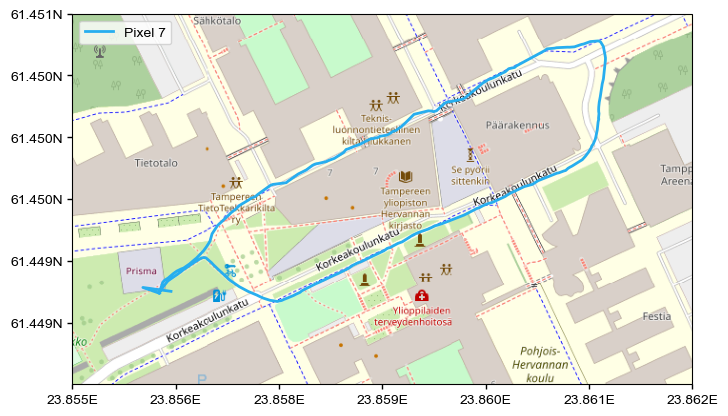

In [9]:
locations = {}
for log in logs:
    locations[log.device] = log.fix.loc[log.fix['provider'].isin(['GPS']), ["latitude", "longitude"]]

plotMap(locations=locations, extent=extent, scale=17)

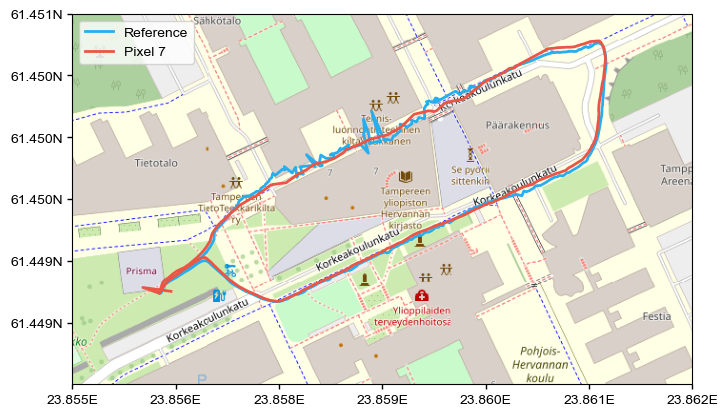

In [10]:

for log in logs:
    locations = {}
    locations['Reference'] = log.pos.df[["latitude", "longitude"]]
    locations[log.device] = log.fix.loc[log.fix['provider'].isin(['GPS']), ["latitude", "longitude"]]
    plotMap(locations=locations, extent=extent, scale=17)

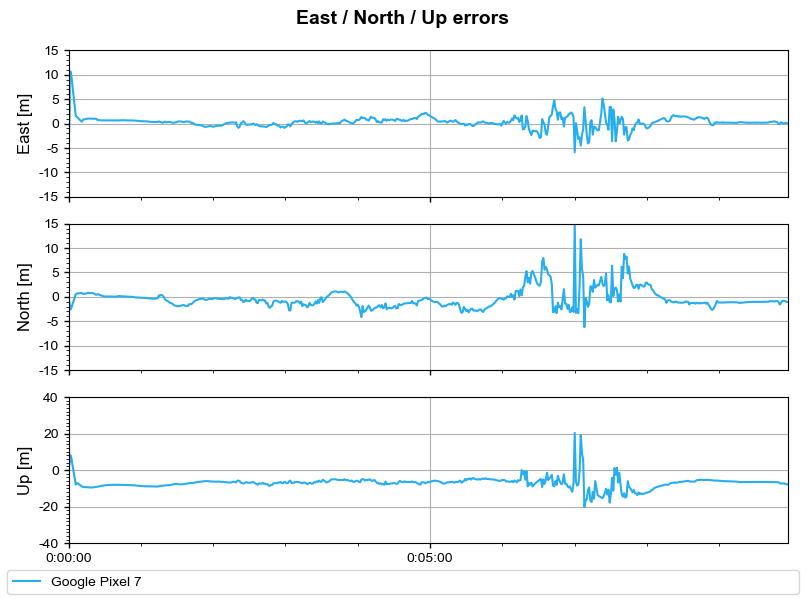

In [11]:
plotENU(logs, lim=[15,15,40], ticks=[1, 5, 1, 5, 2, 20], mode='difference')

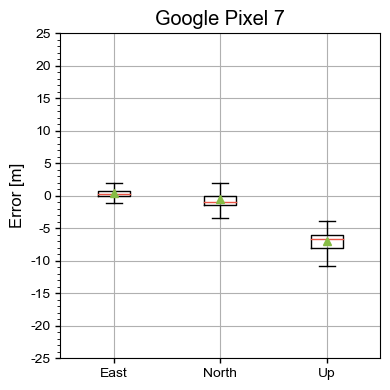

In [12]:
plotStatisticsENU(logs, mode='box', lim=25, ticks=[1, 5])

### Visibility

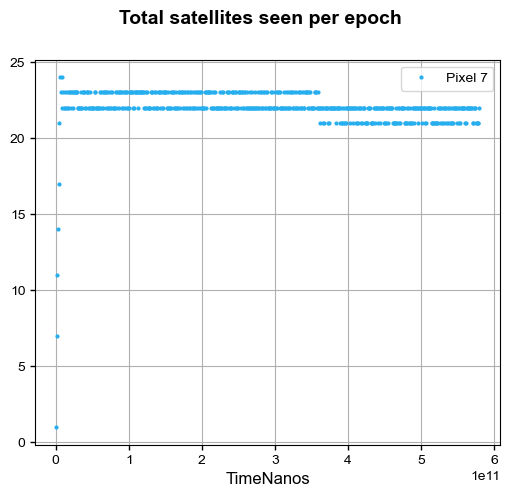

In [13]:
plotTotalSatellitesPerEpochs(logs)

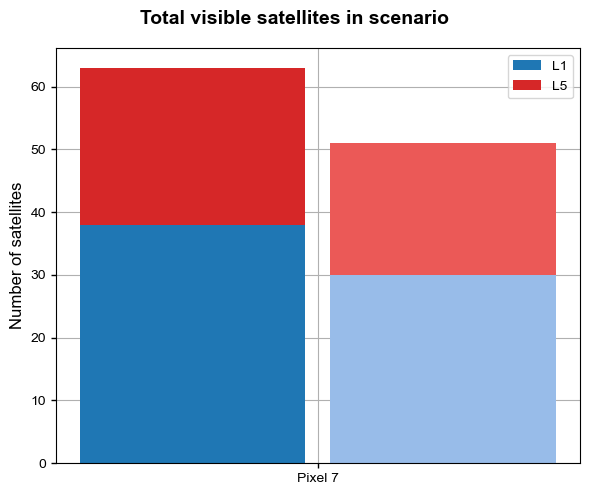

In [14]:
plotTotalSatellitesBar(logs, normalised=False)

### Measurements

Pseudoranges

--- Pixel 7 ---
Rows removed 7 (0.058%)
            Pixel 7
count  12018.000000
mean       0.124266
std        9.751511
min     -153.535509
50%        0.130270
66.7%      1.423095
95%       12.954853
99.7%     42.189841
max      246.958558


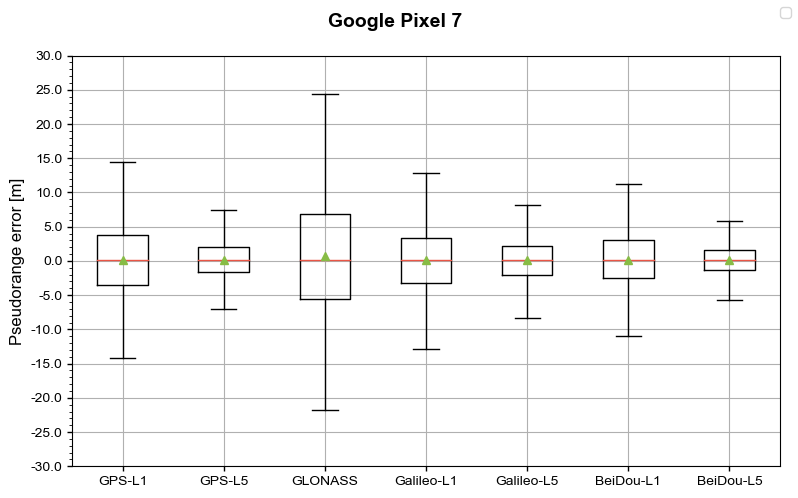

In [15]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw = misc.filterValues(log.raw, 'PseudorangeAcceleration', 300)
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
    stats.append(log.raw['PseudorangeAcceleration'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))

plotStatisticsDataBox(_logs, 
                      'PseudorangeAcceleration', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,5])


--- Pixel 7 ---
Rows removed 1389 (5.376%)
            Pixel 7
count  24447.000000
mean       0.122704
std       23.428013
min     -299.829000
50%        0.075000
66.7%      0.120000
95%        0.596000
99.7%    223.673012
max      299.897000


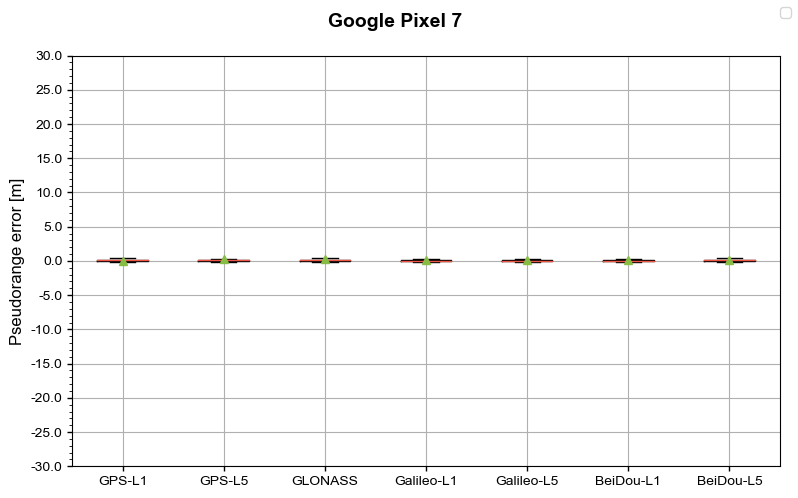

In [16]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'pseudorange_error', 300)
    stats.append(log.ref.df['pseudorange_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))

plotStatisticsDataBox(_logs, 
                      'pseudorange_error', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,5],
                      mode='ref')


In [17]:
_logs = copy.deepcopy(logs)
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
    count = log.raw[list(misc.GnssState_Str.values())].count()
    df = log.raw[list(misc.GnssState_Str.values())].sum().div(count).mul(100).transpose()
    print(df)

--- Pixel 7 ---
TRACK_UNKNOWN                   0.000000
TRACK_CODE_LOCK                72.781296
TRACK_BIT_SYNC                 75.768238
TRACK_SUBFRAME_SYNC            45.617327
TRACK_TOW_DECODED              36.953632
TRACK_MSEC_AMBIGUOUS            0.523888
TRACK_SYMBOL_SYNC              75.799515
TRACK_GLO_STRING_SYNC           2.423958
TRACK_GLO_TOD_DECODED           2.197201
TRACK_BDS_D2_BIT_SYNC           0.000000
TRACK_BDS_D2_SUBFRAME_SYNC      0.000000
TRACK_GAL_E1BC_CODE_LOCK       14.989444
TRACK_GAL_E1C_2ND_CODE_LOCK    27.562749
TRACK_GAL_E1B_PAGE_SYNC         0.000000
TRACK_SBAS_SYNC                 0.000000
TRACK_TOW_KNOWN                96.989600
TRACK_GLO_TOD_KNOWN             2.455235
TRACK_S_2ND_CODE_LOCK          62.280084
dtype: float64


Doppler

--- Pixel 7 ---
Rows removed 0 (0.000%)
            Pixel 7
count  12738.000000
mean       0.075958
std        0.394933
min       -5.145190
50%        0.072259
66.7%      0.147373
95%        0.637539
99.7%      1.816113
max       10.059676


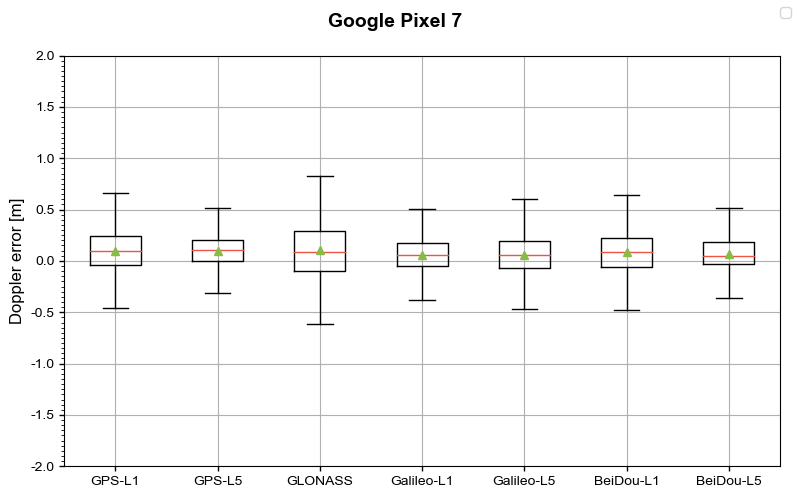

In [18]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw = misc.filterValues(log.raw, 'DopplerError', 30)
    #log.raw = misc.filterPercentile(log.raw, 'DopplerError', 0.997)
    stats.append(log.raw['DopplerError'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))

plotStatisticsDataBox(_logs, 
                      'DopplerError', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5])

--- Pixel 7 ---
Rows removed 15 (0.058%)
            Pixel 7
count  25881.000000
mean      -0.434969
std        1.985353
min      -29.563000
50%       -0.334000
66.7%      0.025000
95%        1.800000
99.7%      6.774440
max       23.425000


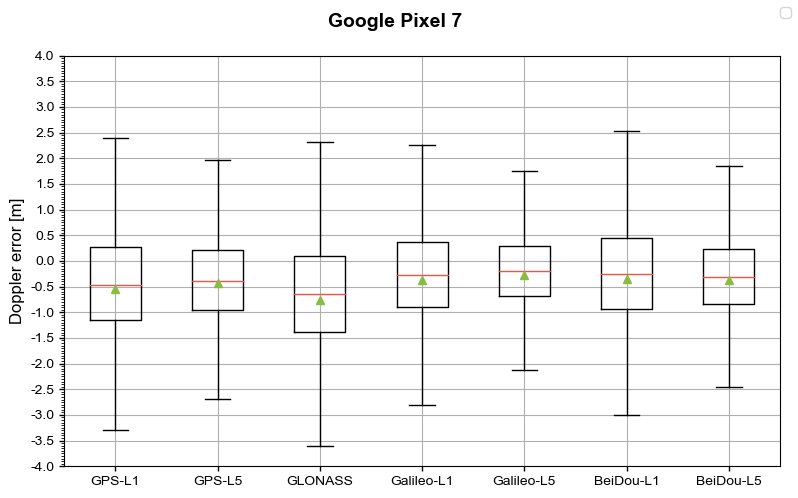

In [19]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'doppler_error', 30)
    #log.raw = misc.filterPercentile(log.raw, 'DopplerError', 0.997)
    stats.append(log.ref.df['doppler_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))

plotStatisticsDataBox(_logs, 
                      'doppler_error', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=4,
                      ticks=[0.05,0.5],
                      mode='ref')

Phases

--- Pixel 7 ---
Rows removed 218 (1.718%)
            Pixel 7
count  12470.000000
mean       0.075095
std        0.376290
min       -5.145190
50%        0.072394
66.7%      0.146343
95%        0.624109
99.7%      1.683756
max        4.176464


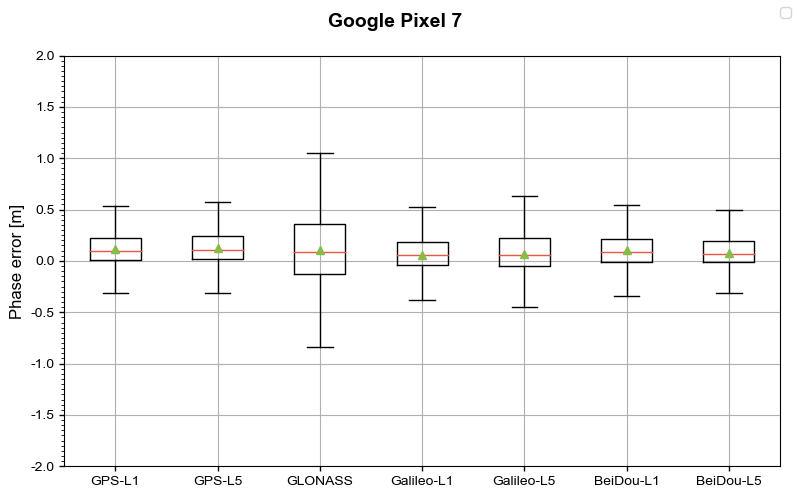

In [20]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    #log.raw = misc.filterPercentile(log.raw, 'PhaseError', 0.997)
    log.raw = misc.filterValues(log.raw, 'PhaseError', 3)
    stats.append(log.raw['DopplerError'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))
plotStatisticsDataBox(_logs, 
                      'PhaseError', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5])
    

--- Pixel 7 ---
Rows removed 1627 (6.297%)
            Pixel 7
count  24209.000000
mean       0.381272
std       18.915576
min     -498.038000
50%        0.331000
66.7%      0.519000
95%        1.457600
99.7%     48.895072
max      497.996000


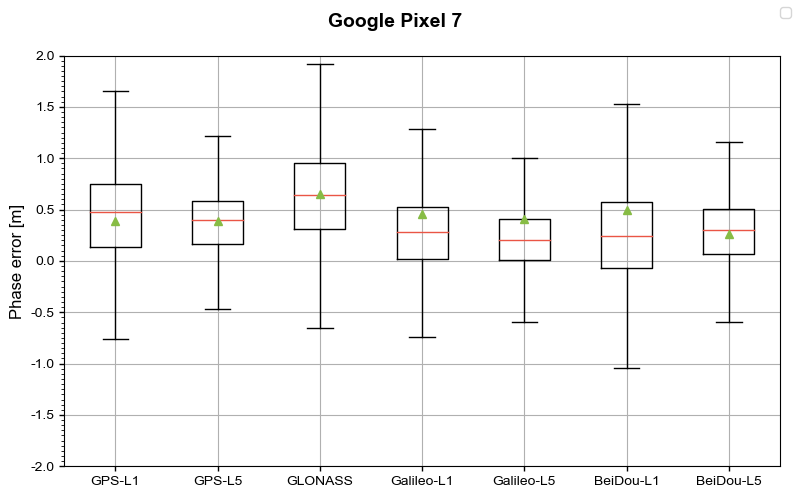

In [21]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'phase_error', 500)
    stats.append(log.ref.df['phase_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))
plotStatisticsDataBox(_logs, 
                      'phase_error', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5],
                      mode='ref')

In [22]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw[list(misc.GnssStateADR_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['AccumulatedDeltaRangeState'], bits=5, type='phase'), axis='columns', result_type='expand')


In [23]:
for log in _logs:
    print(f"--- {log.device} ---")
    count = log.raw[list(misc.GnssStateADR_Str.values())].count()
    print(log.raw[list(misc.GnssStateADR_Str.values())].sum().div(count).mul(100))

--- Pixel 7 ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   43.326296
ADR_RESET                    0.007819
ADR_CYCLE_SLIP               2.932207
ADR_HALF_CYCLE_RESOLVED     37.571350
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64


C/N0

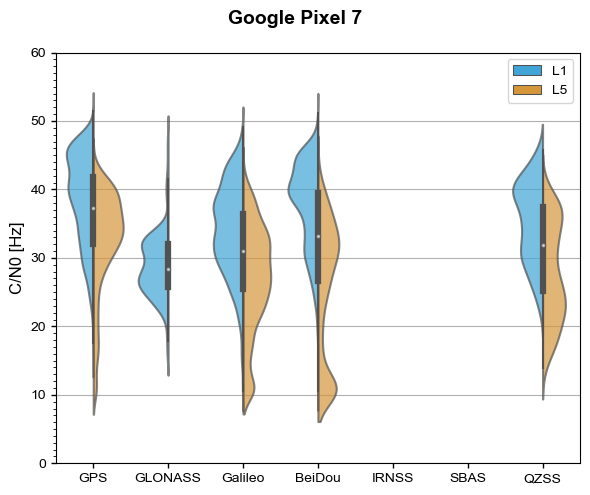

In [24]:
_logs = copy.deepcopy(logs)
plotStatisticsDataViolin(
    _logs, 
    'Cn0DbHz', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10])

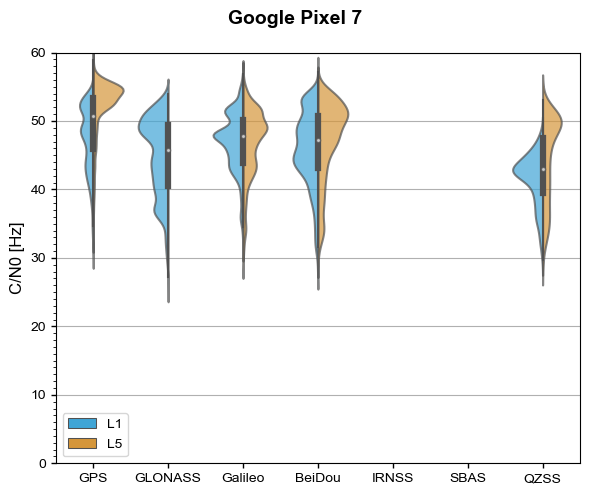

In [25]:
plotStatisticsDataViolin(
    _logs, 
    'snr', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10],
    mode='ref')